### Set up your local Dask cluster.

So as long as you have the Dask extension installed and enabled, there should be a little Dask icon on the left below the stop icon.

**Option 1:** Click `+NEW` cluster. Then you can drag and drop the cluster directly into your notebook or copy and paste the new Scheduler Address into the argument for the Client below.

**Option 2:** You can start a cluster in the notebook using specific number of workers and memory arguments. If you do this, then you will need to copy and paste the scheduler address on the dask taskbar to show widgets related to that cluster. 

Once the cluster is started and connected to the Notebook, I like to open the Dask Graph and Progress tabs.

In [1]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:41348")
# client

In [2]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colorbar import Colorbar # different way to handle colorbar
# plot styles/formatting
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# Extra 
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})
import wrf

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from xarrayMannKendall import *
from plotter import draw_basemap, make_cmap, add_subregion_boxes
from timeseries import select_months


In [3]:
# Set up paths

path_to_data = '/scratch1/08540/dlnash/data/'     # project data -- read only
path_to_data = '/work2/08540/dlnash/frontera/wrf_preprocessed_data/wrf_6km/' # WORK directory
path_to_data = '/home/nash/DATA/data/wrf_hasia/' # great
path_to_out  = '../out/'                          # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'                         # figures


In [4]:
start_date = '1979-12-01'
end_date = '2015-03-31'
mon_s = 12
mon_e = 2

lonmin = 61.
lonmax = 98.
latmin = 22.
latmax = 56.

# subregion info for ar type precip anomalies
ext1 = [66, 74, 37, 43] # Northwestern precip anomalies
ext2 = [71, 79, 32, 37] # Western precip anomalies
ext3 = [90, 100, 24, 30] # Eastern precip anomalies
ext4 = [78, 88, 26, 30] # Central Himalaya region
domains = [ext1, ext2, ext3, ext4]
region_name = ['NW', 'W', 'E', 'C']

# domain extent info 
# [xmin, ymin]
sr_xy = []
sr_width = []
sr_height = []

for i, d in enumerate(domains):
    sr_xy.append([d[0], d[2]])
    sr_width.append((d[1] - d[0]))
    sr_height.append((d[3]- d[2]))


In [5]:
def select_months_ds(ds, mon_s, mon_e):    
    # Select months
    if mon_s > mon_e:
        idx = (ds.time.dt.month >= mon_s) | (ds.time.dt.month <= mon_e)
    else:
        idx = (ds.time.dt.month >= mon_s) & (ds.time.dt.month <= mon_e)
    ds = ds.sel(time=idx)
    return ds

def combine_ar_ds_df(ds, df):
    # Combine AR Cat data w/ WRF data
    # Add ar time series to the WRF dataset
    ds['ar'] = ('time', df.AR_CAT)
    ds = ds.set_coords('ar')

    ds['trackID'] = ('time', df.kidmap)
    ds = ds.set_coords('trackID')
    idx = (ds.ar >= 1)
    # select AR days
    ds_ar = ds.sel(time=idx)
    return ds_ar

def compute_MK_trend_da(da):
    # rename coords lat,lon to y,x because that is what the function needs
    da = da.rename({'lat': 'y', 'lon': 'x'})

    # rechunk dask version of data so it is a single chunk
    da_new = da.chunk({'time': -1})
    # # load data since since it can fit into memory
    da_new = da_new.load()
    
    # Compute trends using Mann-Kendall test - takes roughly 2 seconds!
    MK_class = Mann_Kendall_test(da_new, 'time')
    MK_class = MK_class.compute() 
    return MK_class

### Load WRF 0 deg isotherm data

In [6]:
# get terrain height from one wrf file
wrf_filename = "/work2/08540/dlnash/frontera/wrf_norris/20211113_case/wrfout_d01_2010-02-04_03:00:00"
wrf_filename = "/home/hasia/2009/wrfout_d01_2010-02-04_03:00:00"
wrfin = nc.Dataset(wrf_filename)
ter = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height

In [7]:
varname = 'zerodegisotherm'
domain = 'd01'

filename_pattern = path_to_data + '{0}/{1}/daily/out.wrf6km.{1}.daily_*.nc'.format(domain, varname)
print(filename_pattern)
ds = xr.open_mfdataset(filename_pattern)

ds

/home/nash/DATA/data/wrf_hasia/d01/zerodegisotherm/daily/out.wrf6km.zerodegisotherm.daily_*.nc


<xarray.Dataset>
Dimensions:  (time: 12906, lat: 249, lon: 259)
Coordinates:
  * time     (time) datetime64[ns] 1979-11-30 1979-12-01 ... 2015-03-31
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(32, 249, 259), meta=np.ndarray>

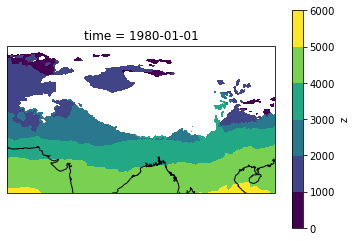

In [8]:
## test plot 1 time step of daily data
ax = plt.axes(projection=ccrs.PlateCarree())

ds.z.sel(time='1980-01-01').plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

### Average height of 0 deg isotherm during each month of winter season (climatology)

In [9]:
# get monthly climatology
ds_clim = ds.groupby("time.month").mean('time')
ds_clim

<xarray.Dataset>
Dimensions:  (month: 12, lat: 249, lon: 259)
Coordinates:
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    z        (month, lat, lon) float32 dask.array<chunksize=(1, 249, 259), meta=np.ndarray>

### Calculate Anomalies

In [10]:
%%time

## load filtered annual climatology
clim_mean = xr.open_dataset(path_to_data + 'd01/zerodegisotherm/filtered_daily_mean_clim_zerodegisotherm.nc')

## Calculate Anomalies
anomalies_daily = ds.groupby('time.dayofyear') - clim_mean

# resample anomalies to monthly
anomalies_mon = anomalies_daily.resample(time="1MS").mean('time')

CPU times: user 14.5 s, sys: 39.1 s, total: 53.5 s
Wall time: 54.8 s


## Plot Monthly Climatology

In [11]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+5,5)
dy = np.arange(latmin,latmax+2,2)

# hack for tick labels
share_right = [False]*2 + [True]

# cmap setup
cmap = cmo.ice
clipcmap = cmocean.tools.crop_by_percent(cmap, 20, which='min', N=None)

mon_sel = [12, 1, 2]
plt_lst = ['(a) December', '(b) January', '(c) February']

/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


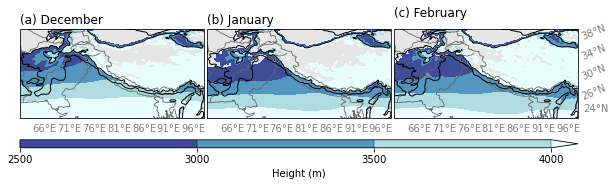

In [12]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.25, cbar_size='3%',label_mode='',
                direction='row')

# Loop for drawing each plot
for k, (ax, mon) in enumerate(zip(axgr, mon_sel)):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k])
    # Data for plotting
    data = ds_clim.z.sel(month=mon)
    lons = data.lon.values
    lats = data.lat.values
    
    # Contour Filled
    cflevs = np.arange(2500, 4500, 500)
    cf = ax.contourf(lons, lats, data.values, transform=datacrs,
                    levels=cflevs,cmap=clipcmap, extend='max')
    
    # # Contour Lines
    # kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
    #               'rightside_up': True, 'use_clabeltext': True}
    # cs = ax.contour(lons, lats, data.values, cflevs, colors='k', linewidth=0.5, linestyles='solid', transform=datacrs)
    # plt.clabel(cs, **kw_clabels)
    
    # Contour Lines (terrain)
    clevs=np.array([1000, 3000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)

    
    # Subtitles
    ax.set_title(plt_lst[k], loc='left', fontsize=12)
#     ax.annotate(plt_lst[k], (5, 237), xycoords='axes points', fontsize=12.,
#                 backgroundcolor='white')

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('Height (m)', fontsize=10)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'zero_isotherm_height_DJF_clim' + '.png'
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()

### Trend of 0 deg isotherm over 35 years

/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


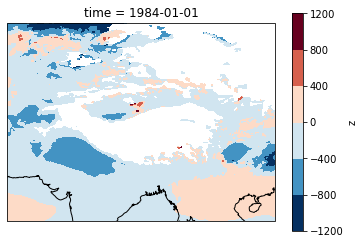

In [13]:
## test plot 1 time step of daily data
ax = plt.axes(projection=ccrs.PlateCarree())

anomalies_mon.z.sel(time='1984-01-01').plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [14]:
%%time

#### compute trend for each month
mon_lst = [12, 1, 2]
final_trend = []
for i, mon in enumerate(mon_lst):
    # select single month
    idx = (anomalies_mon.time.dt.month == mon)
    da = anomalies_mon.z.sel(time=idx)
    trend = compute_MK_trend_da(da)
    final_trend.append(trend)
    
final_trend[0]

/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encou

CPU times: user 9min 1s, sys: 29.2 s, total: 9min 30s
Wall time: 8min 55s


<xarray.Dataset>
Dimensions:    (y: 249, x: 259)
Coordinates:
  * x          (x) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
  * y          (y) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
Data variables:
    trend      (y, x) float64 6.197 6.266 6.33 6.392 6.454 ... nan nan nan nan
    signif     (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    p          (y, x) float64 0.001505 0.00137 0.00137 0.001246 ... 1.0 1.0 1.0
    std_error  (y, x) float64 2.916 2.908 2.902 2.9 2.9 ... nan nan nan nan nan

## Plot Monthly Trend (all days)

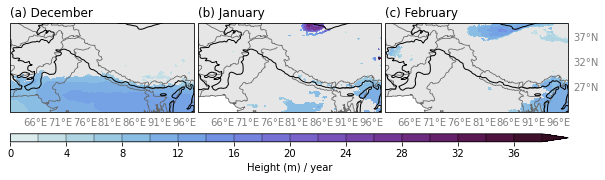

In [15]:
plt_lst = ['(a) December', '(b) January', '(c) February']
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.25, cbar_size='3%',label_mode='',
                direction='row')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k])
    # Data for plotting
    data = final_trend[k].trend.values
    lons = final_trend[k].x.values
    lats = final_trend[k].y.values
    pval_mask = final_trend[k].trend.where((final_trend[k].p <= 0.05)).values
    
    # Contour Filled
    cflevs = np.arange(0, 40, 2)
    cf = ax.contourf(lons, lats, pval_mask, transform=datacrs,
                    levels=cflevs,cmap=cmo.dense, extend='max')
    
    # # Stippling Significant values
    # cs = ax.contourf(lons, lats, pval_mask, colors='none', hatches=['\\'])
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)

    
    # Subtitles
    ax.set_title(plt_lst[k], loc='left', fontsize=12)
#     ax.annotate(plt_lst[k], (5, 237), xycoords='axes points', fontsize=12.,
#                 backgroundcolor='white')

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('Height (m) / year', fontsize=10)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs +'zerodegiso_trend_yearly.png'
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()

### Trend of 0 deg isotherm over AR days DJF

#### Load AR dates and merge with daily anomalies

In [16]:
filepath = path_to_out + 'AR-types_ALLDAYS.csv'
df = pd.read_csv(filepath)

# set times as index
df = df.rename(columns={'Unnamed: 0': 'date'})
df = df.set_index(pd.to_datetime(df['date']))

# select only djf months
idx = (df.index.month >= 12) | (df.index.month <= 2)
df = df.loc[idx]

# normalize datetimes to 00 UTC
df.index = df.index.strftime("%Y-%m-%d")

# set to days available in WRF
idx = (df.index >= '1979-12-01') & (df.index <= '2015-02-28')
df = df.loc[idx]

# # select only ar days
idx = (df['AR_CAT'] > 0)
df = df.loc[idx]

# get list of dates that ar is present
ar_dates = pd.to_datetime(df.index).values

# subset freezing level to just ar days
anomalies_daily = anomalies_daily.sel(time = ar_dates)

# Combine AR Cat and freeze data w/ WRF data
colnames = ['AR_CAT']
for i, col in enumerate(colnames):
    anomalies_daily[col] = ('time', df[col])
    anomalies_daily = anomalies_daily.set_coords(col)
    
anomalies_daily

<xarray.Dataset>
Dimensions:    (time: 1250, lat: 249, lon: 259)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2015-02-27
  * lat        (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon        (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
    dayofyear  (time) int64 335 336 342 343 350 351 355 ... 52 53 54 55 56 57 58
    AR_CAT     (time) int64 2 1 2 1 1 3 1 1 1 3 2 1 ... 2 2 2 2 2 2 1 1 3 3 3 3
Data variables:
    z          (time, lat, lon) float64 dask.array<chunksize=(1, 249, 259), meta=np.ndarray>

#### Calculate Trends

In [17]:
# %%time
# artype_lst = [1, 2, 3]
# final_trend = []

# for i, ar_type in enumerate(artype_lst):
#     print('AR Type:', ar_type)
#     # ## select only type i ARs
#     idx = (anomalies_daily.AR_CAT == ar_type)
#     # select AR days
#     ar_ds = anomalies_daily.sel(time=idx)
    
#     ### aggregate by month - resample to monthly
#     ar_ds_mon = ar_ds.resample(time="MS", skipna=True).mean()
    
#     #### compute trend for each month
#     mon_lst = [12, 1, 2]
#     for j, mon in enumerate(mon_lst):
#         print('Month', mon)
#         # select single month
#         idx = (ar_ds_mon.time.dt.month == mon)
#         da = ar_ds_mon.z.sel(time=idx)
#         trend = compute_MK_trend_da(da)
#         final_trend.append(trend)
        

### Zero degree isotherm trend for AR days broken down by Type and month

In [18]:
# # hack for tick labels
# share_right = [False]*2 + [True] + [False]*2 + [True]
# share_bottom = [False]*3 + [True]*3
# plt_lst = ['(a) December', '(b) January', '(c) February'] + ['']*3
# row_lbl = ['W HMA AR'] + ['']*2 + ['NW HMA AR'] + ['']*2
# # + ['Eastern HMA AR'] + ['']*2
# # Create figure
# fig = plt.figure(figsize=(10,11))
# nrows = 2
# ncols = 3

# # Set up Axes Grid
# axes_class = (GeoAxes,dict(map_projection=mapcrs))
# axgr = AxesGrid(fig, 111, axes_class=axes_class,
#                 nrows_ncols=(nrows, ncols), axes_pad = 0.05,
#                 cbar_location='bottom', cbar_mode='single',
#                 cbar_pad=0.25, cbar_size='3%',label_mode='',
#                 direction='row')

# # Loop for drawing each plot
# for k, ax in enumerate(axgr):
#     ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
#                       left_lats=False, right_lats=share_right[k], bottom_lons=share_bottom)
#     # Data for plotting
#     data = final_trend[k].trend.values
#     lons = final_trend[k].x.values
#     lats = final_trend[k].y.values
#     pval_mask = final_trend[k].trend.where((final_trend[k].p <= 0.05)).values
    
#     # Contour Filled
#     cflevs = np.arange(0, 40, 2)
#     cf = ax.contourf(lons, lats, pval_mask, transform=datacrs,
#                     levels=cflevs,cmap=cmo.dense, extend='max')
    
#     # # Stippling Significant values
#     # cs = ax.contourf(lons, lats, pval_mask, colors='none', hatches=['\\'])
    
#     # Contour Lines (terrain)
#     clevs=np.array([1000])
#     cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
#                     linestyles='solid', transform=datacrs)

    
#     # Subtitles
#     ax.set_title(plt_lst[k], loc='left', fontsize=12)
# #     ax.annotate(plt_lst[k], (5, 237), xycoords='axes points', fontsize=12.,
# #                 backgroundcolor='white')
#     # Row labels
#     ax.text(-0.03, 0.5, row_lbl[k], va='bottom', ha='center',
#         rotation='vertical', rotation_mode='anchor', fontsize=13,
#         transform=ax.transAxes)

# # Colorbar (single)
# cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
# cb.set_label('Height (m) / year', fontsize=10)
# cb.ax.tick_params(labelsize=10)
    
# # Save figure
# filepath = path_to_figs + 'zero_isotherm_height_AR_trend.png'
# plt.savefig(filepath, dpi=300, bbox_inches='tight')

# # Show
# plt.show()

### Trend for DJF broken down by AR type

In [21]:
%%time
artype_lst = [1, 2, 3]
final_trend_all = []
for i, ar_type in enumerate(artype_lst):
    
    # ## select only type i ARs
    idx = (anomalies_daily.AR_CAT == ar_type)
    # select AR days
    ar_ds = anomalies_daily.sel(time=idx)
    
    ### resample to seasonal average
    ar_ssn = ar_ds.resample(time="QS-DEC", skipna=True).mean()
    
    # compute trend for all months - z
    trend = compute_MK_trend_da(ar_ssn.z)
    final_trend_all.append(trend)
    

/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encou

CPU times: user 5min 16s, sys: 26.6 s, total: 5min 42s
Wall time: 5min 26s


In [23]:
len(final_trend)

3

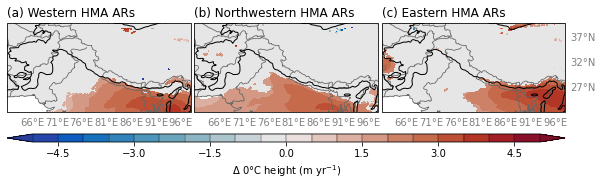

In [36]:
# hack for tick labels
share_right = [False]*2 + [True]
plt_lst = ['(a) Western HMA ARs', '(b) Northwestern HMA ARs', '(c) Eastern HMA ARs']
# ['Eastern HMA ARs']
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.25, cbar_size='3%',label_mode='',
                direction='row')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k])
    # Data for plotting
    data = final_trend_all[k].trend.values
    lons = final_trend_all[k].x.values
    lats = final_trend_all[k].y.values
    pval_mask = final_trend_all[k].trend.where((final_trend_all[k].p <= 0.05)).values
    
    # Contour Filled
    cflevs = np.arange(-5, 5.5, .5)
    clipcmap = cmocean.tools.crop_by_percent(cmo.balance, 20, which='both', N=None)
    cf = ax.contourf(lons, lats, pval_mask, transform=datacrs,
                    levels=cflevs,cmap=clipcmap, extend='both')
    
    # # Stippling Significant values
    # cs = ax.contourf(lons, lats, pval_mask, colors='none', hatches=['\\'])
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)

    
    # Subtitles
    ax.set_title(plt_lst[k], loc='left', fontsize=12)
#     ax.annotate(plt_lst[k], (5, 237), xycoords='axes points', fontsize=12.,
#                 backgroundcolor='white')

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(u'$\Delta$ 0\N{DEGREE SIGN}C height (m yr$^{-1}$)', fontsize=10)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'zero_isotherm_height_AR_trend_DJF.png'
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()

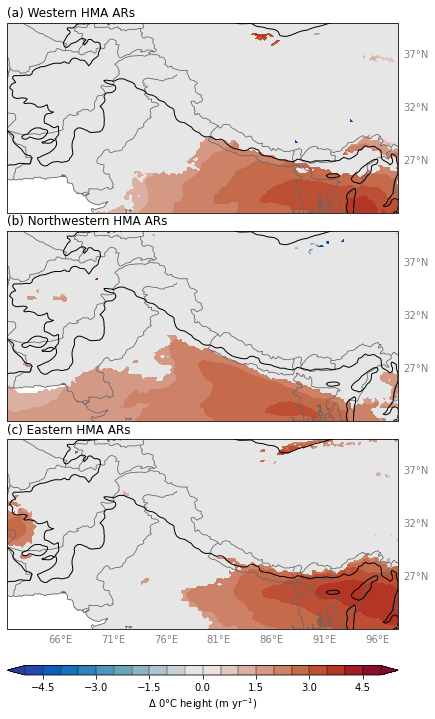

In [35]:
# hack for tick labels
share_bottom = [False]*2 + [True]
plt_lst = ['(a) Western HMA ARs', '(b) Northwestern HMA ARs', '(c) Eastern HMA ARs']
# ['Eastern HMA ARs']
# Create figure
fig = plt.figure(figsize=(10,12))
nrows = 3
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.25,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.25, cbar_size='5%',label_mode='',
                direction='row')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,40.], xticks=dx, yticks=dy,
                      left_lats=False, right_lats=True, bottom_lons=share_bottom[k])
    # Data for plotting
    data = final_trend_all[k].trend.values
    lons = final_trend_all[k].x.values
    lats = final_trend_all[k].y.values
    pval_mask = final_trend_all[k].trend.where((final_trend_all[k].p <= 0.05)).values
    
    # Contour Filled
    cflevs = np.arange(-5, 5.5, .5)
    clipcmap = cmocean.tools.crop_by_percent(cmo.balance, 20, which='both', N=None)
    cf = ax.contourf(lons, lats, pval_mask, transform=datacrs,
                    levels=cflevs,cmap=clipcmap, extend='both')
    
    # # Stippling Significant values
    # cs = ax.contourf(lons, lats, pval_mask, colors='none', hatches=['\\'])
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)

    
    # Subtitles
    ax.set_title(plt_lst[k], loc='left', fontsize=12)
#     ax.annotate(plt_lst[k], (5, 237), xycoords='axes points', fontsize=12.,
#                 backgroundcolor='white')

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(u'$\Delta$ 0\N{DEGREE SIGN}C height (m yr$^{-1}$)', fontsize=10)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'zero_isotherm_height_AR_trend_DJF_portrait.png'
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()